In [1]:
import google.colab.drive
google.colab.drive.mount('gdrive')

Mounted at gdrive


In [4]:
import numpy as np
import cv2
import torch
import glob
import os
import datetime
import json
import sys

### input information and params ###
"""
start_T, end_T(int, > 0):
You can set frames which are applied to WormTracer.
If you want to use all frames, set both start_T and end_T as 0.

rescale(float, > 0, < 1):
You can change the scale of image to use for tracing by this value.
If MEMORY ERROR occurs, set this value lower.
For example if you set it 0.5, the size of images will be half of the original.
Default value is 1.

Tscale(int, > 0):
You can reduce frames by thinning out the movie by this value.
If MEMORY ERROR occurs, set this value higher.
For example, if you set it to 2, even-numbered frames will be picked up.
This parameter is useful in case frame rate is too high.
Default value is 1.

continuity_loss_weight(float, > 0):
This value is the weight of the continuity constraint.
Around 10000 is recommended, but if the object moves fast, set it lower.

smoothness_loss_weight(float, > 0):
This value is the weight of the smoothness constraint.
Around 50000 is recommended, but if the object bends sharply, set it lower.

length_loss_weight(float, > 0):
This value is the weight of the length continuity constraint.
Around 50 is recommended, but if length of the object changes drastically, set it lower.

center_loss_weight(float, > 0):
This value is the weight of the center position constraint.
Around 50 is recommended.

plot_n(int, > 1):
This value is plot number of center line.
Around 100 is recommended.

epoch_plus(int, > 0):
This value is additional training epoch number.
After annealing is finished, training will be performed for at most epoch_plus times.
Over 1000 is recommended.

speed(float, > 0):
This value is speed of annealing progress.
The larger this value, the faster the learning is completed.
0.1 is efficient, 0.05 is cautious.

lr(float, > 0):
This value is learning rate of training.
Around 0.05 is recommended.

body_ratio(float, > 0):
This value is body (rigid part of the object) ratio of the object.
If the object is a typical worm, set it around 90.

num_t(int, > 0):
This value means the number of images which are displayed
when show_image function is called.
Default value is 5.
If you want to see all frames, set it to "np.inf".

show_progress_freq(int, > 0):
This value is epoch frequency of displaying tracing progress.

save_progress_freq(int, > 0):
This value is epoch frequency of saving tracing progress.

save_progress_num(int, > 0):
This value is the number of images that are included in saved progress tracing.
"""

dataset_path = "/content/gdrive/MyDrive/WormTracer/WT"
functions_path = "/content/gdrive/MyDrive/WormTracer"
extension = "png"

params = {}
params['start_T'] = 0
params['end_T'] = 0
params['rescale'] = 1
params['Tscale'] = 1

params['continuity_loss_weight'] = 10000
params['smoothness_loss_weight'] = 100000
params['length_loss_weight'] = 50
params['center_loss_weight'] = 50

params['plot_n'] = 100
params['epoch_plus'] = 1500
params['speed'] = 0.05
params['lr'] = 0.05
params['body_ratio'] = 90

display_option = {}
display_option['num_t'] = 5 #np.inf
display_option['show_progress_freq'] = 200
display_option['save_progress_freq'] = 50
display_option['save_progress_num'] = 50
display_option['ShowProgress'] = False
display_option['SaveProgress'] = False

#### make use of GPU ####
if torch.cuda.is_available():
  device = 'cuda'
  print('Running using GPU.')
else:
  device = 'cpu'
  print('Running using CPU. GPU is recommended')

In [5]:
sys.path.append(functions_path)
from functions import *

# read data property(image size, frame number)
filenames_all = sorted(glob.glob(os.path.join(dataset_path, "*."+extension)))
filenames_full = filenames_all[:params['end_T']][params['start_T']:] if params['end_T'] else filenames_all[params['start_T']:]
filenames = filenames_full[::params['Tscale']]
imshape, Worm_is_black = get_property(filenames, params['rescale'])

# read images and get information
# getting xy plots by thinning in function ; read_image_and_xy()
real_image, x, y, y_st, x_st, unitLength, pre_width = read_image_and_xy(imshape, filenames, params['rescale'], params['plot_n'], Worm_is_black)
theta = make_theta_from_xy(x, y)
print('\rframe = ', len(filenames),' shape = ', real_image.shape, " unitLength = ", unitLength)

frame =  1500  shape =  (1500, 165, 169)  unitLength =  1.1337672154383256



        Warning! This task uses large memory.
        If CUDA run out of memory, please go back to setting hyperparameters and set rescale as 0.42, Tscale as 1.
        The result may be not precise enough.
        


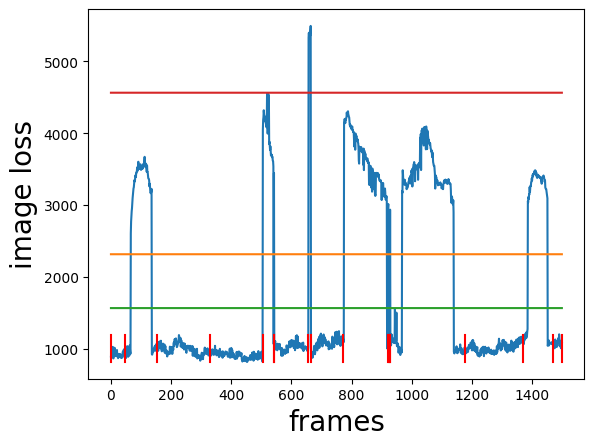

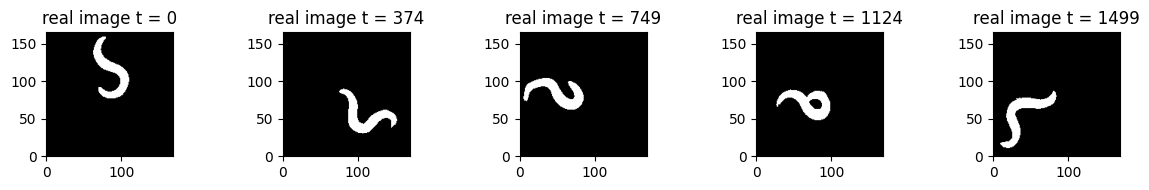

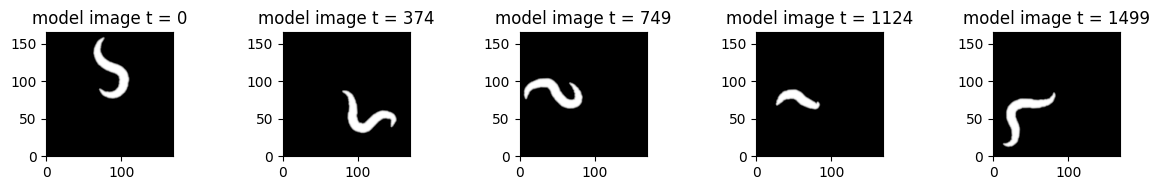

use_points 
 [   0   48  153  328  504  541  543  655  666  772  920  923  927  929
 1178 1369 1468 1499]


In [ ]:
# make worm model image from plots
params['alpha'] = pre_width.min()
image_info = {'image_shape':real_image.shape, 'device':device}
cap_span = calc_cap_span(image_info, params['plot_n'], s_m=8000)
model_image = make_image(x, y, x_st, y_st, params, image_info, cap_span)

# get points for trace region
image_losses = np.mean((model_image - real_image)**2, axis=(1,2))
image_loss_max = get_image_loss_max(image_losses, real_image, x, y, x_st, y_st, params, image_info, cap_span)
use_points, nont_flag, simple_area = get_use_points(image_losses, image_loss_max, cap_span, x, y, params['plot_n'], show_plot=True)

show_image(real_image, display_option['num_t'], title='real image')
show_image(model_image, display_option['num_t'], title='model image')
print('use_points \n',use_points)

(0, 20)


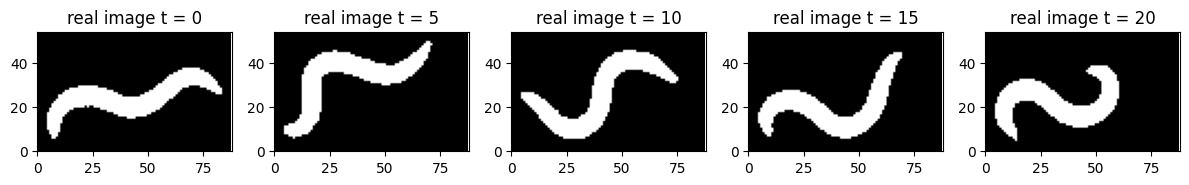

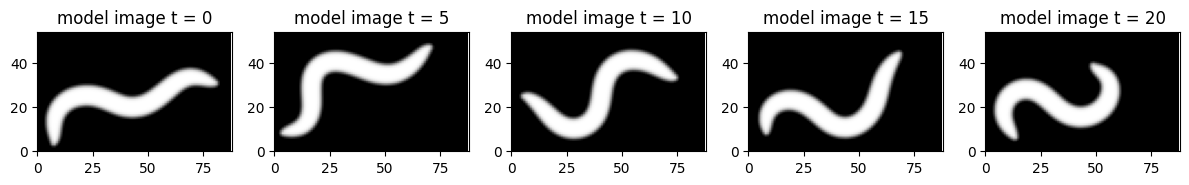

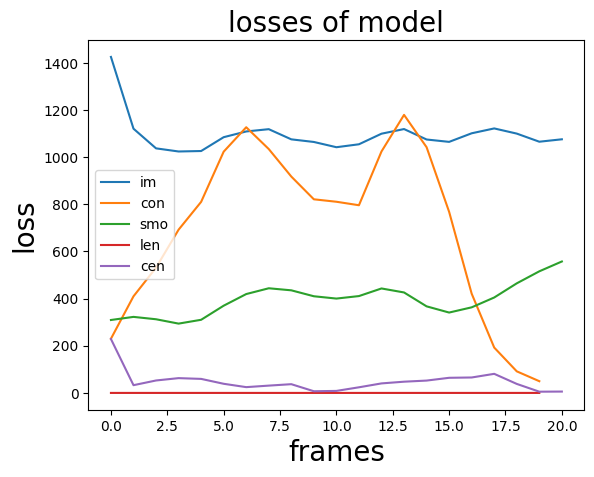

In [ ]:
losses_all = []; shape_params = [];
unitLength = prepare_for_train(pre_width, simple_area, x, y, params)
if display_option['SaveProgress']:
  clear_dir(dataset_path, 'progress_image')

# main loop 1
for i in range(len(use_points)-1):
  if nont_flag[i]:
    losses_all.append(0)
    continue
  use_area = (use_points[i], use_points[i+1])
  print(use_area); display_option['use_area'] = use_area
  filenames_ = filenames[use_area[0]:use_area[1]+1]
  T = use_area[1] - use_area[0] + 1
  theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

  # read and preprocess images
  real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
  show_image(real_image, display_option['num_t'], title='real image')
  save_progress(real_image, dataset_path, display_option, txt='real')
  image_info['image_shape'] = real_image.shape

  # set init value
  theta_cand, _ = make_thetaCand(theta_)
  theta_[-1,:] = theta_cand[0]
  init_cx, init_cy = set_init_xy(real_image)
  init_theta = torch.tensor(theta_)
  init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
  init_data = [init_cx, init_cy, unitLength]

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  display_option['id'] = 0
  losses = train3(model, real_image, optimizer, params, device, display_option, init_data, dataset_path, is_nont=False)

  # get trace information
  losses_all.append(losses)
  theta_model = model.theta.detach().cpu().numpy()
  unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
  x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
  shape_params.append((T, model.alpha.detach().cpu(), model.gamma.detach().cpu(), model.delta.detach().cpu()))
  model_image = model()
  show_image(model_image, display_option['num_t'], title='model image')
  show_loss_plot(losses_all[-1], title='losses of model')

  # reconstruct plots from model results
  x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
  x[use_area[0]:use_area[1]+1,:] = x_model + x_st
  y[use_area[0]:use_area[1]+1,:] = y_model + y_st

(20, 49)


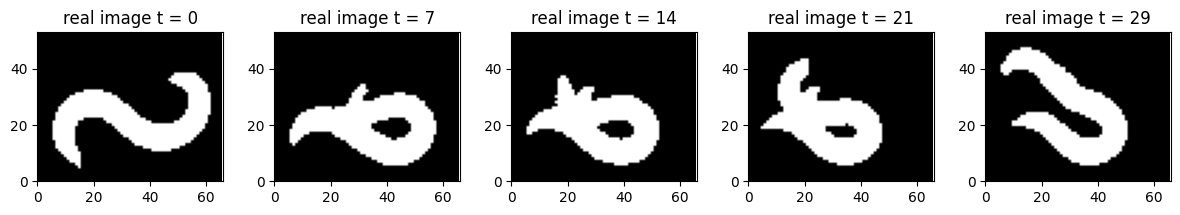

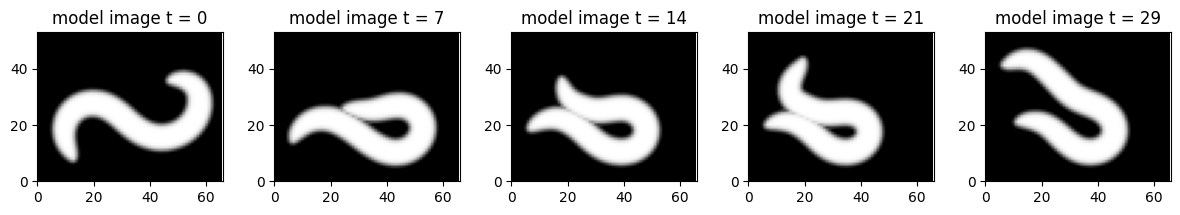

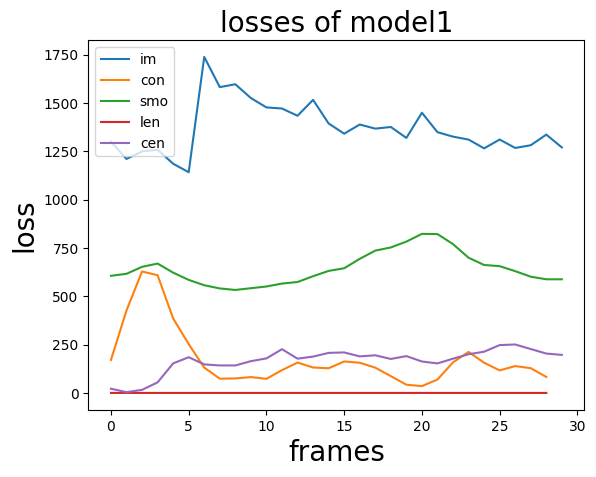

In [ ]:
params['init_alpha'], params['init_gamma'], params['init_delta'] = get_shape_params(shape_params, params)

# main loop 2
for i in range(len(use_points)-1):
  if not nont_flag[i]:
    continue
  use_area = (use_points[i], use_points[i+1])
  print(use_area); display_option['use_area'] = use_area
  filenames_ = filenames[use_area[0]:use_area[1]+1]
  T = use_area[1] - use_area[0] + 1
  theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

  # read and preprocess images
  real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
  show_image(real_image, display_option['num_t'], title='real image')
  save_progress(real_image, dataset_path, display_option, txt='real')
  image_info['image_shape'] = real_image.shape

  # make flipping theta candidate
  theta_cand, _ = make_thetaCand(theta_)

  # set init value
  init_cx, init_cy = set_init_xy(real_image)
  init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[0], T))
  init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
  init_data = [init_cx, init_cy, unitLength]

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  display_option['id'] = 0
  losses_all[i] = train3(model, real_image, optimizer, params, device, display_option, init_data, dataset_path)

  # get trace information
  theta_model = model.theta.detach().cpu().numpy()
  unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
  x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
  model_image = model()

  # flip final theta to trace again
  init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[1], T))

  # make model instance and training
  model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
  display_option['id'] = 1
  losses = train3(model, real_image, optimizer, params, device, display_option, init_data, dataset_path)

  # get trace information if loss is smaller
  select_ind = loss_compair([losses_all[i], losses])
  if select_ind:
    theta_model = model.theta.detach().cpu().numpy()
    unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
    x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
    model_image = model()
    losses_all[i] = losses
  remove_progress(dataset_path, '{}-{}_id{}*.png'.format(use_area[0], use_area[1], 1-select_ind))

  # reconstruct plots from model results
  x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
  show_image(model_image, display_option['num_t'], title='model image')
  show_loss_plot(losses_all[i], title='losses of model{}'.format(select_ind))
  x[use_area[0]:use_area[1]+1,:] = x_model + x_st
  y[use_area[0]:use_area[1]+1,:] = y_model + y_st

In [ ]:
# revise areas which have too large loss
losslarge_area = find_losslarge_area(losses_all)

for i in range(len(use_points)-1):
  if losslarge_area[i] and nont_flag[i]:
    use_area = (use_points[i], use_points[i+1])
    print(use_area[0], ":", use_area[1], " too large loss! ")
    display_option['use_area'] = use_area
    filenames_ = filenames[use_area[0]:use_area[1]+1]
    T = use_area[1] - use_area[0] + 1
    theta_ = theta[use_area[0]:use_area[1]+1,:].copy()

    # read and preprocess images
    real_image, y_st, x_st = read_image(imshape, filenames_, params['rescale'], Worm_is_black)
    show_image(real_image, display_option['num_t'], title='real image')
    image_info['image_shape'] = real_image.shape

    # make flipping candidate
    _, theta_cand = make_thetaCand(theta_)

    # set init value
    init_cx, init_cy = set_init_xy(real_image)
    init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[0], T))
    init_unitLength = torch.ones(T, dtype=torch.float)*unitLength
    init_data = [init_cx, init_cy, unitLength]

    # make model instance and training
    update = 0
    model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    display_option['id'] = 2
    losses = train3(model, real_image, optimizer, params, device, display_option, init_data, dataset_path)

    # get trace information if loss is smaller
    if loss_compair([losses_all[i], losses]):
      print("update")
      update = 2
      theta_model = model.theta.detach().cpu().numpy()
      unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
      x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
      model_image = model()
      losses_all[i] = losses
      remove_progress(dataset_path, '{}-{}_id[0-1]*.png'.format(use_area[0], use_area[1]))
    else:
      print("no update")
      remove_progress(dataset_path, '{}-{}_id2*.png'.format(use_area[0], use_area[1]))

    # flip final theta and trace again
    init_theta = torch.from_numpy(np.linspace(theta_[0,:], theta_cand[1], T))

    # make model instance and training
    model = Model(init_cx, init_cy, init_theta, init_unitLength, image_info, params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    display_option['id'] = 3
    losses = train3(model, real_image, optimizer, params, device, display_option, init_data, dataset_path)

    # get trace information if loss is smaller
    if loss_compair([losses_all[i], losses]):
      print("update")
      update = 3
      theta_model = model.theta.detach().cpu().numpy()
      unitL_model = model.unitLength.detach().cpu().numpy().reshape(-1,1)
      x_cent, y_cent = model.cx.detach().cpu().numpy(), model.cy.detach().cpu().numpy()
      model_image = model()
      losses_all[i] = losses
      remove_progress(dataset_path, '{}-{}_id[0-2]*.png'.format(use_area[0], use_area[1]))
    else:
      print("no update")
      remove_progress(dataset_path, '{}-{}_id3*.png'.format(use_area[0], use_area[1]))

    if update:
      x_model, y_model = make_plot(theta_model, unitL_model, x_cent, y_cent)
      show_image(model_image, display_option['num_t'], title='model image')
      show_loss_plot(losses_all[i], title='losses of new model')

      # reconstruct plots from model results
      x[use_area[0]:use_area[1]+1,:] = x_model + x_st
      y[use_area[0]:use_area[1]+1,:] = y_model + y_st

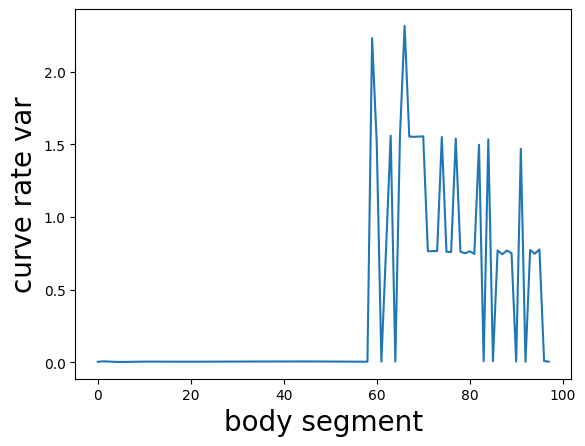

In [ ]:
# save params and plots
params_for_save = params.copy()
for key, value in params_for_save.items():
  if torch.is_tensor(value):
    params_for_save[key] = params_for_save[key].item()

# check flipping
x, y = flip_check(x, y)
# check which side is head or tail
x, y = judge_head(x, y)
# cancel reduction
T_read_all = params['end_T'] - params['start_T'] if params['end_T'] else len(filenames_all) - params['start_T']
x, y = cancel_reduction(x, y, T_read_all, len(filenames), params['plot_n'])

foldername = 'results'
time_now = datetime.datetime.now()

if not os.path.isdir(os.path.join(dataset_path, foldername)):
  os.mkdir(os.path.join(dataset_path, foldername))

with open(os.path.join(dataset_path,foldername,'{}_params.json'.format(time_now)), "w") as f:
  json.dump(params_for_save, f)
np.savetxt(os.path.join(dataset_path,foldername,'{}_x.csv'.format(time_now)), x/params['rescale'], delimiter=',')
np.savetxt(os.path.join(dataset_path,foldername,'{}_y.csv'.format(time_now)), y/params['rescale'], delimiter=',')

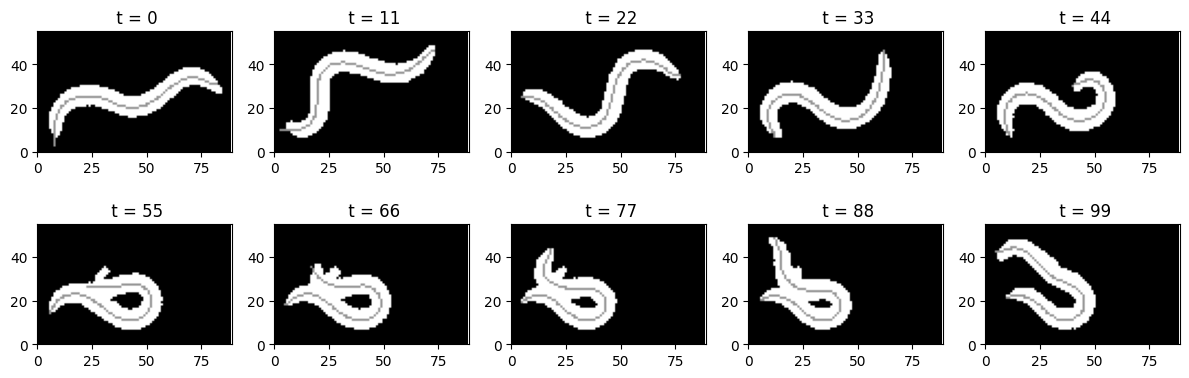

In [ ]:
# show full of real_image and line
real_image, y_st, x_st = read_image(imshape, filenames_full, params['rescale'], Worm_is_black)

real_image_RGB = np.tile(real_image[:,:,:,np.newaxis], (1,1,1,3))
y_int = y.astype(np.int16) - y_st
y_int[y_int>=real_image.shape[1]] = real_image.shape[1]-1
x_int = x.astype(np.int16) - x_st
x_int[x_int>=real_image.shape[2]] = real_image.shape[2]-1

for t in range(len(filenames_full)):
  real_image_RGB[t, y_int[t,:], x_int[t,:], :] = 150

show_image(real_image_RGB, 10)#np.inf)

In [ ]:
# save full of real_image and line
foldername = 'full_line_image'

clear_dir(dataset_path, foldername)
for t in range(len(filenames)):
  filename = os.path.join(dataset_path, foldername, foldername+str(t).zfill(len(str(len(filenames))))+'.png')
  cv2.imwrite(filename, real_image_RGB[t,:,:,:])

NameError: ignored